# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import os
import random
import cv2
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Check GPU Availability

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# EDA

## Visualize Sample Data

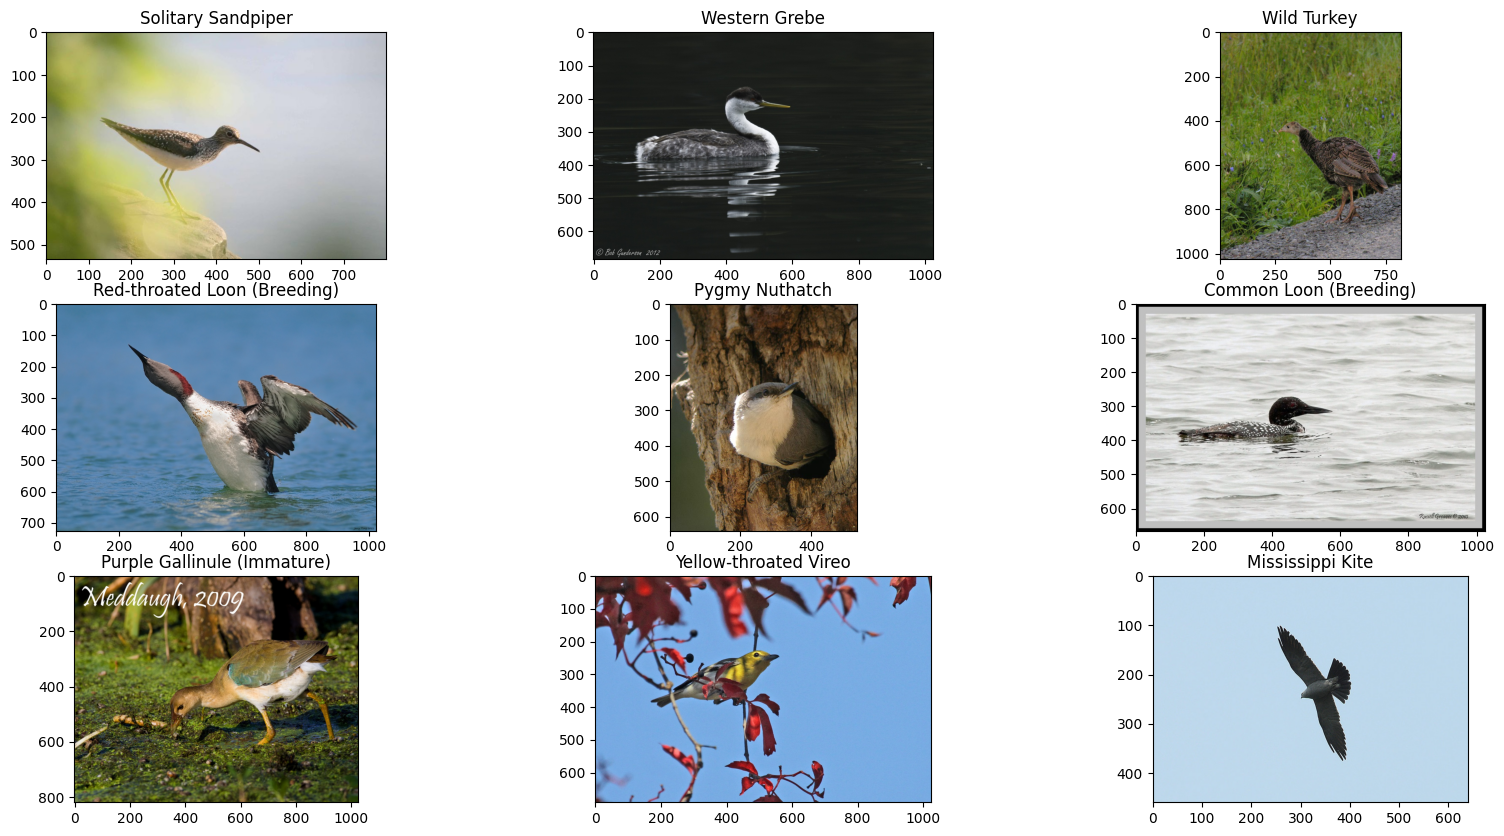

In [3]:
num_sample = 9
root = "/kaggle/input/birds23sp/birds/train/"

classes = []
with open("/kaggle/input/birds23sp/birds/names.txt") as f:
    classes.extend(f.readlines())
    
plt.figure(figsize = (20, 10))
for i in range(num_sample):
    random_class = random.randint(0, 554)
    class_name = classes[random_class].strip().split("\n")[0]
    class_path = os.path.join(root, str(random_class))
    files = os.listdir(class_path)
    image = random.choice(files)
    image_path = os.path.join(class_path, image)
    image = load_img(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)

## Sample Size Distribution
Class distribution is uneven. The class with the most instances is ten times the class with the least instances. The standard deviation is also very big.

total images: 38562
min class: Dark-eyed Junco (White-winged), num: 10
max class: White-winged Dove, num: 106
standard deviation: 22.06846640893006


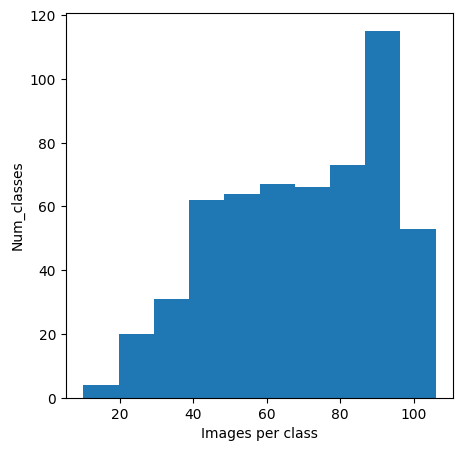

In [4]:
path = "/kaggle/input/birds23sp/birds/train/"

num = 555
class_num = []
for i in range(num):
    class_path = os.path.join(path, str(i))
    files = os.listdir(class_path)
    class_num.append(len(files))

plt.figure(figsize = (5, 5))
plt.xlabel("Images per class")
plt.ylabel("Num_classes")
plt.title("")
plt.hist(class_num)

print(f"total images: {np.sum(class_num)}")
print(f"min class: {classes[np.argmin(class_num)].strip()}, num: {min(class_num)}")
print(f"max class: {classes[np.argmax(class_num)].strip()}, num: {max(class_num)}")
print(f"standard deviation: {np.std(class_num)}")

## Image Size Statistics

avg image height: 711.886001763394
avg image width: 898.0834500285255
min image width: 90
max image width: 1024
standard deviation: 173.71986785146


(array([6.0000e+00, 1.9000e+01, 1.4000e+02, 4.9600e+02, 1.3120e+03,
        3.5760e+03, 2.4650e+03, 5.5080e+03, 1.5090e+03, 2.3531e+04]),
 array([  90. ,  183.4,  276.8,  370.2,  463.6,  557. ,  650.4,  743.8,
         837.2,  930.6, 1024. ]),
 <BarContainer object of 10 artists>)

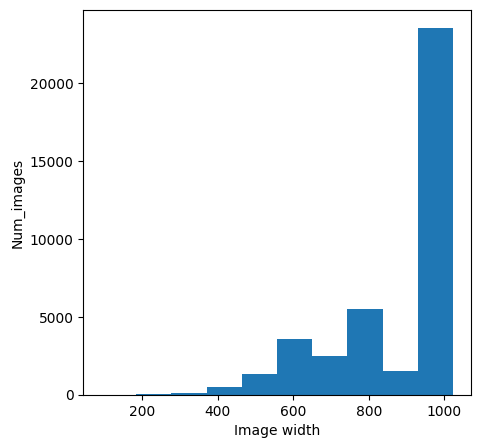

In [5]:
height_list = []
width_list = []
for i in range(num):
    class_path = os.path.join(path, str(i))
    files = os.listdir(class_path)
    for file in files:
        image_path = os.path.join(class_path, file)
        height, width = cv2.imread(image_path).shape[:2]
        height_list.append(height)
        width_list.append(width)

print(f"avg image height: {np.mean(height_list)}")
print(f"avg image width: {np.mean(width_list)}")
print(f"min image width: {min(width_list)}")
print(f"max image width: {max(width_list)}")
print(f"standard deviation: {np.std(width_list)}")

plt.figure(figsize = (5, 5))
plt.xlabel("Image width")
plt.ylabel("Num_images")
plt.title("")
plt.hist(width_list)

## Image Augmentation Visualization

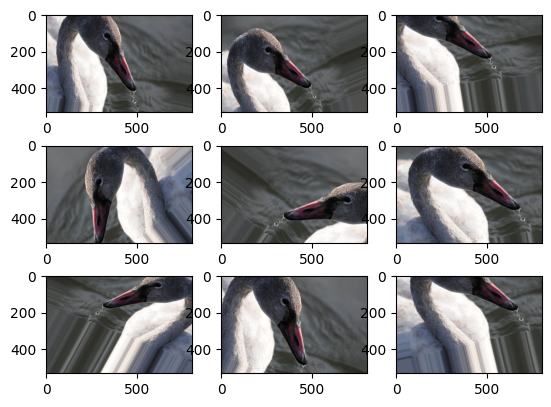

In [6]:
img = load_img("/kaggle/input/birds23sp/birds/train/0/0b23d29cb6364a33a450f1f4fca010ac.jpg")
#plt.imshow(img)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             fill_mode = "nearest",
                             horizontal_flip=0.5)

os.makedirs("/kaggle/working/augmented_data")

i=0
for img_batch in datagen.flow(x, batch_size=3, save_to_dir = "/kaggle/working/augmented_data"):
    img_batch = img_batch.reshape(img_batch.shape[1:])
    img_batch = array_to_img(img_batch)
    image = img_batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    i += 1
    if i >= 9:
        break

# Weight Sampler

In [7]:
sample_weights = []

for i in range(num):
    sample_weights.append(1 / class_num[i])
    
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples= 555 * 70)

# Data Preprocessing

Here our data preprocessing pipeline includes image augmentation and train val splitting. 

In [8]:
def get_bird_data(batch_size=64, train_val_pct=0.2):
    transform_data = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.RandomRotation(degrees=(0,180)),
        transforms.RandomGrayscale(),
        transforms.GaussianBlur(kernel_size=35),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/train', transform=transform_data)
    
    num_data = len(dataset)
    num_val = int(num_data * train_val_pct)
    num_train = num_data - num_val
    
    trainset, valset = random_split(dataset, [num_train, num_val])
    
    trainset.dataset.transform = transform_train
    valset.dataset.transform = transform_test
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True,)
    valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
    
    testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
    
    classes = open("/kaggle/input/birds23sp/birds/names.txt").read().strip().split("\n")
    
    # Backward mapping to original class ids (from folder names) and species name (from names.txt)
    class_to_idx = dataset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data(batch_size=32)

## Some Augmented Images

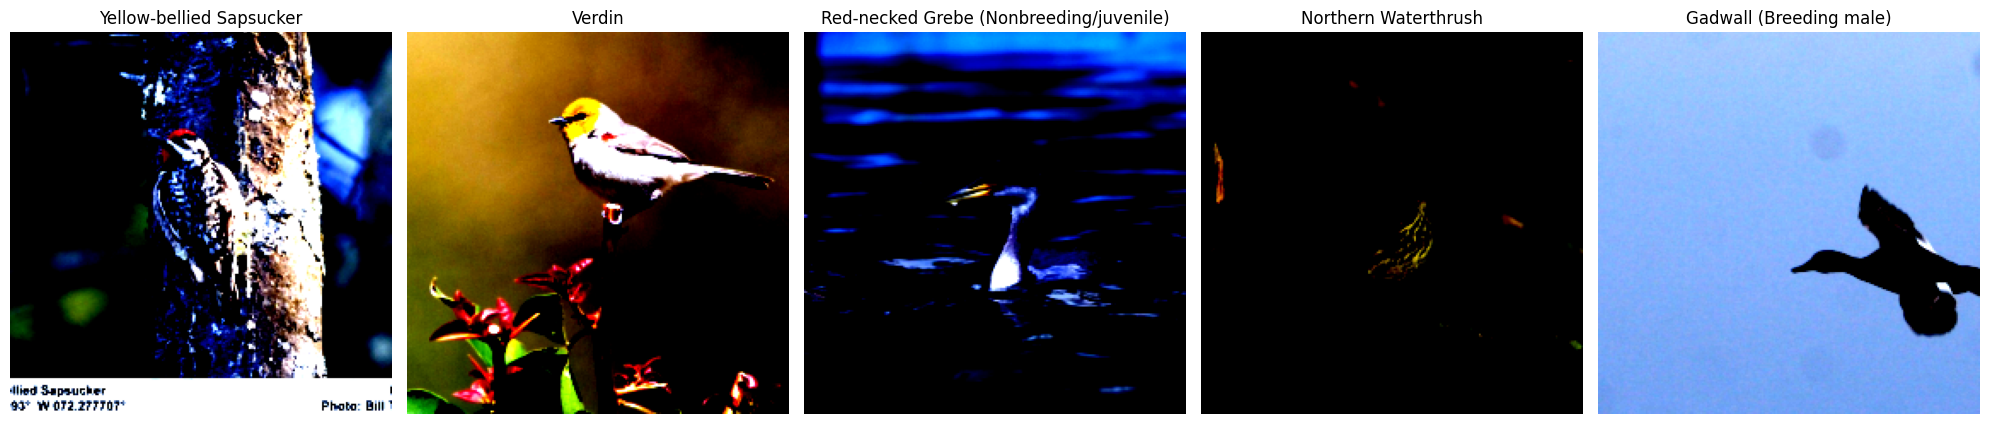

In [9]:
trainloader = data['train']

# Get a batch of images from the trainloader
images, labels = next(iter(trainloader))

# Visualize the images
fig, axes = plt.subplots(figsize=(20, 10), ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0))  # Transpose image tensor from CxHxW to HxWxC
    ax.axis('off')
    ax.set_title(data['to_name'][labels[i].item()])
plt.tight_layout()
plt.show()

# Training

The function doesn't include the weight sampler because we found that it even decrease the performance of our model predictions on the leaderboard. But theoretically, it should work better.

In [10]:
def train(net, trainloader, valloader, epochs=10, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    losses_val = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
#     optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']
        losses_val = state['losses_val']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        running_loss = 0.0
        sum_loss_val = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]
                
        num_train = 0
        for i, batch in enumerate(trainloader, 0):
            
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()
            running_loss += loss.item()
            
            num_train += 1

            if i % print_every == print_every-1:    # print every 100 mini-batches
                if verbose:
                    print('[epoch %d, batch %d] train loss: %.3f' % (epoch, i + 1, running_loss / print_every))
                    running_loss = 0.0
            
        net.eval()
        
        with torch.no_grad():
            num_val = 0
            for inputs, labels in valloader:
                inputs = inputs.to(device)  # Move inputs to the device
                labels = labels.to(device)
                outputs = net(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                sum_loss_val += loss.item()
                num_val += 1
                
            losses_val.append(sum_loss_val / num_val)
            
        if verbose:
            print('[epoch %d] train loss: %.3f, val loss: %.3f' % (epoch, sum_loss / num_train, sum_loss_val / num_val))
            
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pth'%(epoch+1))
    return losses, losses_val

## Load Pretrained Models

Download [MaxViT: Multi-Axis Vision Transformer](http://arxiv.org/abs/2204.01697) (tiny version). Change the output size of the last layer to 555.

In [11]:
maxvit = torchvision.models.maxvit_t(weights='DEFAULT')
maxvit.classifier[5] = nn.Linear(512, 555)
print(maxvit)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /root/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:07<00:00, 16.4MB/s]

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

Download [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) (small version). Change the output size of the last layer to 555.

In [12]:
convnext = torchvision.models.convnext_small(weights='DEFAULT')
convnext.classifier[2] = nn.Linear(768, 555)
print(convnext)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:11<00:00, 17.3MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

Download [Swin Transformer V2: Scaling Up Capacity and Resolution](https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_Swin_Transformer_V2_Scaling_Up_Capacity_and_Resolution_CVPR_2022_paper.pdf) (tiny version). Change the output size of the last layer to 555.

In [13]:
swin = torchvision.models.swin_v2_t(weights='DEFAULT')
swin.head = nn.Linear(768, 555)
print(swin)

Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:06<00:00, 16.3MB/s]

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

### Start Training or Load Weight Files

In [14]:
# losses, losses_val = train(maxvit, data['train'], data['val'], epochs=10, checkpoint_path='/kaggle/working/', print_every=100, lr=0.005)
cp_max = torch.load('/kaggle/input/birds-classification-models/maxvit-t-checkpoint-8.pth')
maxvit.load_state_dict(cp_max['net'])

<All keys matched successfully>

In [15]:
# losses, losses_val = train(convnext, data['train'], data['val'], epochs=15, checkpoint_path='/kaggle/working/', print_every=100, lr=0.005)
cp_conv = torch.load('/kaggle/input/birds-classification-models/convnext-small-checkpoint-8.pth')
convnext.load_state_dict(cp_conv['net'])

<All keys matched successfully>

In [16]:
# losses, losses_val = train(swin, data['train'], data['val'], epochs=15, checkpoint_path='/kaggle/working/', print_every=100, lr=0.005)
cp_swin = torch.load('/kaggle/input/birds-classification-models/swin-v2-t-checkpoint-7.pth')
swin.load_state_dict(cp_swin['net'])

<All keys matched successfully>

In [17]:
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

# Ensemble

## Compute the Best Coefficient for Ensemble of Two Models

In [18]:
def compute_weight_2(net1, net2):
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    accuracies = []
    alphas = []
    
    for alpha in range(5, 96, 5):
        print(alpha)
        num_correct = 0
        total = 0
        for i, batch in enumerate(data['val'], 0):
            if i%100==0: print(i, end = ' ')
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs1 = net1(inputs)
            outputs2 = net2(inputs)
            outputs = outputs1*alpha/100 + outputs2*(1-alpha/100)
            _, pred = torch.max(outputs.data, 1)
            for p, l in zip(pred, labels):
                total += 1
                if p == l: num_correct += 1
            if i==999: break
        print()
        accuracies.append(num_correct / total)
        alphas.append(alpha/100)
        
    weights = {}
    
    for i in range(len(accuracies)):
        weights[accuracies[i]] = alphas[i]
        
    sortedWeights = dict(sorted(weights.items()))
    
    print(sortedWeights)
    
    return sortedWeights

The result shows that the best coefficient between MaxViT and ConvNeXt is 0.6 : 0.4.

In [19]:
# weights = compute_weight_2(maxvit, convnext)

## Compute the Best Coefficient for Ensemble of Three Models

In [20]:
def compute_weight_3(net1, net2, net3, weight1):
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    net3.to(device)
    net3.eval()
    accuracies = []
    alphas = []
    
    for alpha in range(5, 96, 5):
        print(alpha)
        num_correct = 0
        total = 0
        for i, batch in enumerate(data['val'], 0):
            if i%100==0: print(i, end = ' ')
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs1 = net1(inputs)
            outputs2 = net2(inputs)
            outputs12 = outputs1 * weight1 + outputs2 * (1 - weight1)
            outputs3 = net3(inputs)
            outputs = outputs12*alpha/100 + outputs3*(1-alpha/100)
            _, pred = torch.max(outputs.data, 1)
            for p, l in zip(pred, labels):
                total += 1
                if p == l: num_correct += 1
            if i==999: break
        print()
        accuracies.append(num_correct / total)
        alphas.append(alpha/100)
        
    weights = {}
    
    for i in range(len(accuracies)):
        weights[accuracies[i]] = alphas[i]
        
    sortedWeights = dict(sorted(weights.items()))
    
    print(sortedWeights)
    
    return sortedWeights

The result shows that the best coefficient between MaxViT, ConvNeXt, and Swin Transformer V2 is 0.39 : 0.26 : 0.35.

In [21]:
# weights = compute_weight_3(maxvit, convnext, swin, 0.6)

# Prediction

Prediction using one model. 

In [22]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

Prediction using two models. 

In [23]:
def predict_ensemble_2(net1, net2, weight, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs1 = net1(images)
            outputs2 = net2(images)
            outputs = outputs1*weight + outputs2*(1-weight)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

Prediction using three models. 

In [24]:
def predict_ensemble_3(net1, net2, net3, weight1, weight2, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    net3.to(device)
    net3.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs1 = net1(images)
            outputs2 = net2(images)
            outputs12 = outputs1*weight1 + outputs2*(1-weight1)
            outputs3 = net3(images)
            outputs = outputs12*weight2 + outputs3*(1-weight2)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

Final submission. This version gets 1st place (1/32) in both the public and private leaderboard during 2023 Spring, with the accuracy of 88% and 88.212%.

In [25]:
# uncomment this to generate predictions
# predict_ensemble_3(maxvit, convnext, swin, 0.6, 0.65, data['test'], "submissions_ensemble_maxvit_t_convnext_s_swin_v2_t.csv")

# Code References
[Data Preprocessing Template](https://www.kaggle.com/code/yuriihalychanskyi/cse-455-final-birds)

[Training and Prediction Template](https://www.kaggle.com/code/pjreddie/transfer-learning-to-birds-with-resnet18)

[Ensemble Template](https://github.com/parkr98/Bird_Identification)

# Additional Comments
Since this is a code competition that is held every time [CSE 455](https://courses.cs.washington.edu/courses/cse455/23sp/) is scheduled by Professor [Joseph Redmon](https://pjreddie.com/), we don't expect blind copying of our codes and results. We strongly encourage other competitors to explore the data and train different models themselves, and our code could be a starter that helps them achieve better performance in the competition.